# Bsc25 - Active training

## Summary

After setting up a CRF model, as well as code to retrieve sequences for that model, the next step was developing an active training environment.

A few definitions:
- 'token': the technical "equivalent" of a word
- 'sequence': an ordered set of tokens
- 'file': an ordered set of sequences (ignoring the speaker layer here)

We added an 'Ofrom_gen' class to 'ofrom_pos' for all subsequent operations. It parses our dataset by grouping sequences into 'files' and providing for each file the number of occurrences for each word (using 'table' as a Pandas DataFrame). This lets us select files, either randomly or by using confidence scores. 

Our tasks here will be:
1. Passive training
2. Active training (fixed)
3. Active training (variable)

In each case we will train models starting with a subset of our dataset, then iteratively add sequences and retrain on the new subset until we match the entire dataset. When training a model, we actually train five: each time selecting (at random) a different part to serve for testing so that, at the end, all tokens still get a confidence score. 
* By 'Passive training' we mean the traditional way to train a model. We could directly train a model on the entire dataset but still iterate to compare with the two other tasks. Additional files are always selected at random until all files are exhausted.
* By 'Active training' we mean an initial subset selected at random, from which we use confidence scores to select additional files.
* By 'fixed' we mean the set of words (derived from lowest confidence scores) that decides the next files to select doesn't change between iterations. This is done to track the evolution of their confidence score across iterations. Conversely 'variable' means the set of words is renewed at each iteration.

The objective is to compare the accuracy score with accruing data between passive/active strategies, as well as the improvement on a fixed set of tokens.

In [5]:
import ofrom_crf # requires scikit-learn & sklearn_crfsuite
import ofrom_pos # requires joblib, zipfile, networkx, ...
import matplotlib.pyplot as plt

In [6]:
gen = ofrom_pos.Ofrom_gen(f="")
# gen.load_dataset("ofrom_alt.joblib") # parses data
# gen.save()                           # saves parsed data
gen.load_parsed("ofrom_gen.joblib")    # load pre-parsed data

## Passive training

We will iterate over batches of ~10,000 tokens (by selecting files randomly) and retrain a model each time. The iterator returns an accuracy score (average of all 5 models trained on the current subset) as well as 10 words with the lowest confidence score. 

In [9]:
def passive():
    c, x, y = 0, [], []
    plt.title("Passive accuracy")
    plt.xlabel("Token count (thousands)")
    plt.ylabel("Accuracy score")
    for acc_score, l_toks in gen.iter_passive(lim=10000, nb=10):
        c += 1; x.append(c*10); y.append(acc_score)
        print(f"iteration: {c}", end="          \r")
        if c >= 10:
            break
    plt.plot(x, y)
    plt.show()

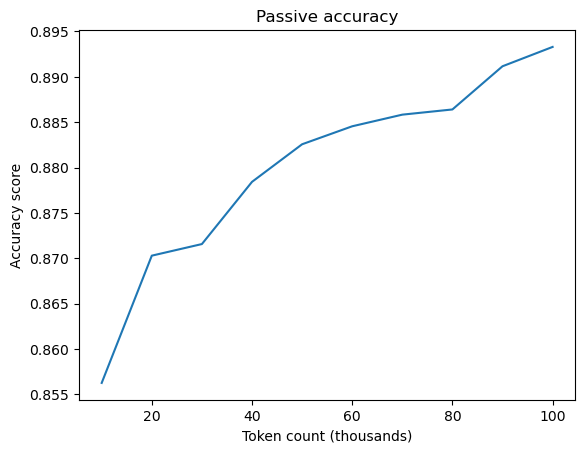

In [10]:
passive()

## Active training (fixed)

We do the same but this time by selecting files according to the 10 tokens with the lowest confidence score.

The formula is 'sum(nb_occurrences*(1-confidence_score))', that is for each token the number of its occurrences (in a given file) multiplied by its confidence score as a weight. 

In [41]:
def get_active(ch_fixed=False, nb_toks=10):
    """Common part between fixed/variable active training."""
    c, x, y, l_y = 0, [], [], [[] for a in range(nb_toks)]
    for acc_score, l_toks in gen.iter_active(lim=10000, nb=nb_toks, 
                                             ch_fixed=ch_fixed):
        c += 1; x.append(c*10); y.append(acc_score)
        for i in range(len(l_y)): # confidence scores
            l_y[i].append(l_toks[i][1])
        print(f"iteration: {c}", end="          \r")
        if c >= 10:
            break
    return x, y, l_y, [tok[0] for tok in l_toks]
def active_fixed(nb_toks=10):
    """Plots the result of active training 
       (with a fixed set of tokens)."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].set_title("Active accuracy (fixed)")
    ax[0].set_xlabel("Token count (thousands)")
    ax[0].set_ylabel("Accuracy score")
    ax[1].set_title("Token confidence score")
    ax[1].set_xlabel("Token count (thousands)")
    ax[1].set_ylabel("Confidence score")
    x, y, l_y, l_lgd = get_active(True, nb_toks)
    ax[0].plot(x, y)
    for i, vy in enumerate(l_y):
        ax[1].plot(x, vy, label=l_lgd[i])
    ax[1].legend()
    plt.show()

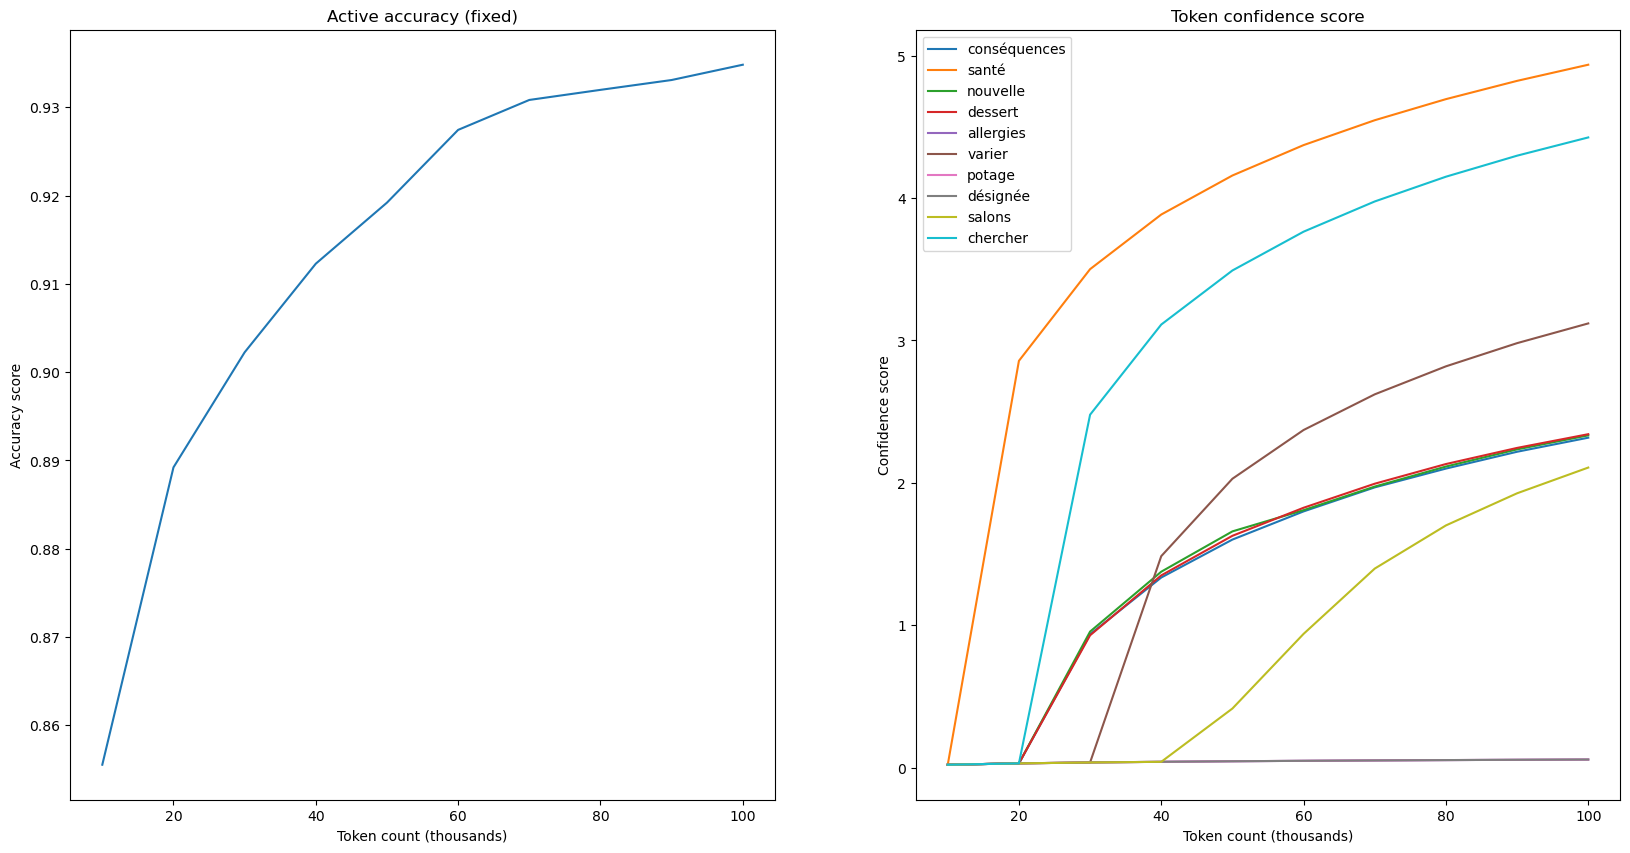

In [43]:
active_fixed()

## Active training (variable)

Finally, we let the active training pick new tokens (based on low confidence) at each iteration.

We expect this approach to reach a better accuracy quicker than other approaches.

In [35]:
def active_variable(nb_toks=10):
    """Plots the result of active training
       (with tokens varying between iterations)."""
    plt.title("Active accuracy (variable)")
    plt.xlabel("Token count (thousands)")
    plt.ylabel("Accuracy score")
    x, y, l_y, l_lgd = get_active(False, nb_toks)
    plt.plot(x, y)
    plt.show()

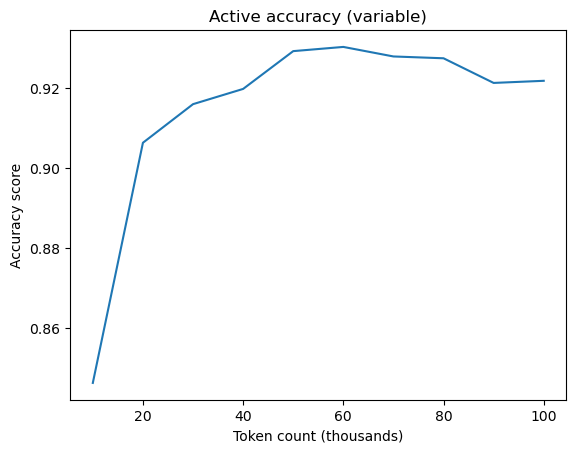

In [37]:
active_variable()

## Conclusion

With 100k tokens (occurrences), a passive training could not reach a 0.9 accuracy score. The code was run multiple times and that threshold was never met.

With ~50k tokens, an active training can reach 0.92.

Our experiment here was limited to 100k tokens (in 10 iterations) due to time constraints and testing purposes. It will be interesting to see how the accuracy evolves past that limit as the variable approach has so far plateau'ed at 0.92, likely by accruing files with problematic cases. We could expect that plateau to end at some point. 

The fixed approach shows a more regular learning curve. However, due to the random (and small) nature of our initial subset, the selected tokens are "meaningless", that is, several of them could be considered non-problematic. 